In [1]:
import pandas as pd
import geopandas as gpd
from sklearn import tree
from ymaps.sync import SearchClient, StaticClient
from shapely.geometry import Point, Polygon
from IPython.display import Image, display

## Описание

В этой тетради мы эксперементируем со следующими инструментами:

* `YandexMaps API`: `SearchClient`, `StaticClient`
* Geopandas: отрисовка объектов
* `Sklearn`: прогноз по дереву решений

Цель: основываясь на координатах книжных магазинов и магазинов алкоголя, мы прогнозируем жильцы каких общажитий *условно* будут больше читать.

Термины:

* Центр города: центр объекта **Каменный мост**
* Смещение от центра: смещение равное расстоянию от *центра* до **Прилук**
* Границы города: квадрат стороны которого *смещены от центра* на указанное выше растояние

Далее алгоритм действий:

1. С помощью `API` яндекса находим координаты объектов по следующим запросам:
    1. 'Книжный магазин'
    2. 'Алкогольный магазин'
    3. 'Общежитие'
2. Так же с помощью `API` `Yandex`-а отрисовываем растровую карту Вологды
3. Отрисовываем все найденные множества точек
    1. Площадь города **лазурным** цветом
    2. Центр города **фиолетовым** цветом
    3. Сами точки заданным цветом
        1. Книжные магазины: синим
        2. Алкогольные: красным
        3. Общажития: зелёным
4. Основываясь на первых двух наборах обучаем модель `DecisionTreeClassifier`
5. Прогнозируем на пятом наборе
6. Выводим результат

Комментарии:

При поиске было необходимо установить опцию ограничения поиска `rspn` в `False`
так как при установки в `True` количество результатов очень снижалось.

### Грузим ключ

In [2]:
f = open('api_key.txt', 'r')
key = f.read()

### Создаём объекты API Yandex-а

In [3]:
search = SearchClient(key)
static = StaticClient()

### Задаём параметры поиска

In [4]:
# Координаты
lon = 39.891057
lat = 59.220514
ll = [lon, lat]

# Размах
offset = 0.05
spn=[offset, offset]

# Поиск
booksSearch = 'Книжный магазин'
alcoSearch = 'Алкогольный магазин'
houseSearch = 'Общежитие'
rspn=False
results = 50

# Карта
l = ['sat']
size = [450, 450]

### Определяем функцию трансляции формата Yandex-а в Geopandas

In [5]:
def getGeoSeries(json):
    properties = json['properties']
    ResponseMetaData = properties['ResponseMetaData']
    SearchResponse = ResponseMetaData['SearchResponse']
    found = SearchResponse['found']
    print('Found: {0}'.format(found))
    
    features = json['features']
    items = list()
    for feature in features:
        pos = feature['geometry']['coordinates']
        items.append(Point(pos))
    
    return gpd.GeoSeries(items)

### Обращаемся к API Yandex-а и переводим в формат Geopandas

In [6]:
bookJson = search.search(
    query=booksSearch,
    results=results,
    ll=ll,
    spn=spn,
    rspn=rspn,
    type='biz')

In [7]:
bookShopItems = getGeoSeries(bookJson)

Found: 29


In [8]:
alcoJson = search.search(
    query=alcoSearch,
    results=results,
    ll=ll,
    spn=spn,
    rspn=rspn,
    type='biz')

In [9]:
alcoShopItems = getGeoSeries(alcoJson)

Found: 92


In [10]:
houseJson = search.search(
    query=houseSearch,
    results=results,
    ll=ll,
    spn=spn,
    rspn=rspn,
    type='biz')

In [11]:
houseItems = getGeoSeries(houseJson)

Found: 40


### Задаём полигон границ города и точку центра

In [12]:
# lu - left upper, lb - left bottom
# ru - right upper, rb - right bottom
lu_lon = lon - offset
lu_lat = lat + offset
lb_lon = lon - offset
lb_lat = lat - offset
ru_lon = lon + offset
ru_lat = lat + offset
rb_lon = lon + offset
rb_lat = lat - offset
lon_lat_list = [
    [lu_lon, lu_lat],
    [ru_lon, ru_lat],
    [rb_lon, rb_lat],
    [lb_lon, lb_lat]]
borders = Polygon(lon_lat_list)
center = Point(ll)

### Задаём функцию отрисовки объектов

In [13]:
def plotItems(items, color, borders, center):
    gdfBorders = gpd.GeoDataFrame(geometry=[borders])
    gdfBorders['color'] = 'azure'
    gdfCenter = gpd.GeoDataFrame(geometry=[center])
    gdfCenter['color'] = 'maroon'
    gdfItems = gpd.GeoDataFrame(geometry=items)
    gdfItems['color'] = color
    gdfItems = pd.concat([gdfBorders, gdfCenter, gdfItems])
    gdfItems.plot(color=gdfItems['color'], figsize=(8,8))

### К сожалению в geopandas не получается подставить карту под графики
#### Так что попробуйте пока использовать воображение :)

In [14]:
data = static.getimage(ll=ll, l=l, size=size, spn=spn)
img = Image(data, width=600)

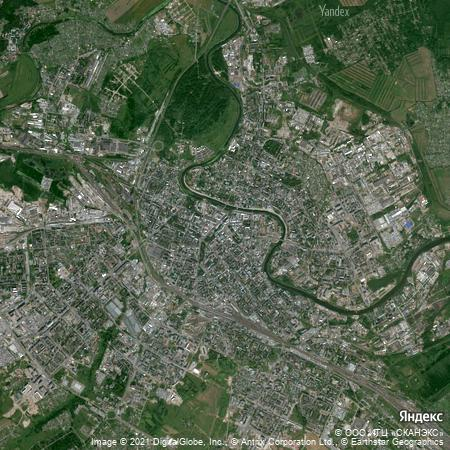

In [15]:
display(img)

### Расположения книжных магазинов

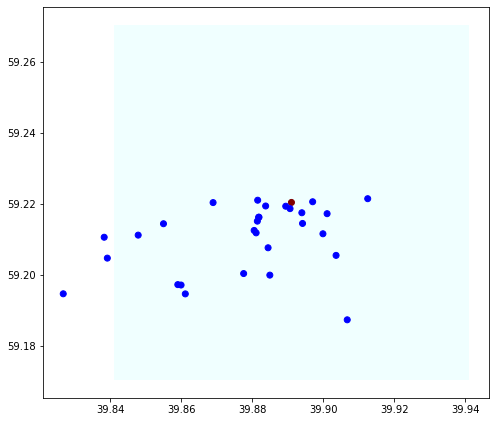

In [16]:
plotItems(bookShopItems, 'blue', borders, center)

### Расположение алкогольных магазинов

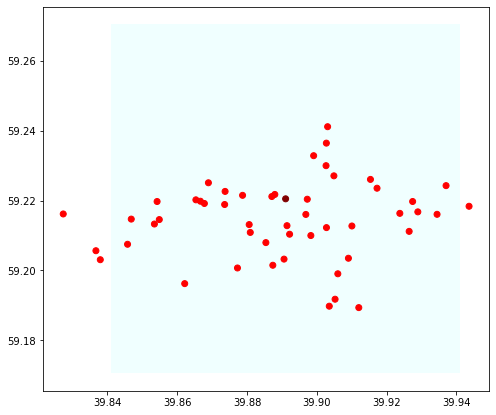

In [17]:
plotItems(alcoShopItems, 'red', borders, center)

### Расположение общажитий

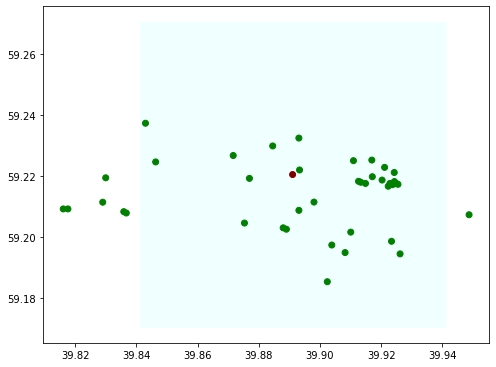

In [18]:
plotItems(houseItems, 'green', borders, center)

### Готовим данные для обучения

In [19]:
dfBooks = pd.DataFrame()
dfAlco = pd.DataFrame()
dfHouse = pd.DataFrame()

In [20]:
dfBooks['lon'] = pd.DataFrame(bookShopItems.x)
dfBooks['lat'] = pd.DataFrame(bookShopItems.y)
dfAlco['lon'] = pd.DataFrame(alcoShopItems.x)
dfAlco['lat'] = pd.DataFrame(alcoShopItems.y)
dfHouse['lon'] = pd.DataFrame(houseItems.x)
dfHouse['lat'] = pd.DataFrame(houseItems.y)

In [21]:
# Сохраняем наборы данных

dfBooks.to_csv('books.csv', index=False)
dfAlco.to_csv('alco.csv', index=False)
dfHouse.to_csv('house.csv', index=False)

In [22]:
dfBooks['book'] = True
dfAlco['book'] = False

In [23]:
dfBooks.head(3)

,lon,lat,book
0,39.893984,59.217613,True
1,39.883791,59.219514,True
2,39.889447,59.219449,True


In [24]:
dfAlco.tail(3)

,lon,lat,book
47,39.837965,59.203069,False
48,39.862148,59.196219,False
49,39.902639,59.230011,False


In [25]:
frames = [dfBooks, dfAlco]
df = pd.concat(frames)
df = df.reset_index(drop=True)
df

,lon,lat,book
0,39.893984,59.217613,True
1,39.883791,59.219514,True
2,39.889447,59.219449,True
3,39.894176,59.214597,True
4,39.890660,59.218769,True
...,...,...,...
74,39.912020,59.189349,False
75,39.943610,59.218378,False
76,39.837965,59.203069,False
77,39.862148,59.196219,False


### Делим данные на X и Y

In [26]:
x = df.iloc[:,:2]
y = df.iloc[:,2:]

In [27]:
x.head(3)

,lon,lat
0,39.893984,59.217613
1,39.883791,59.219514
2,39.889447,59.219449


In [28]:
y.head(3)

,book
0,True
1,True
2,True


### Запускаем обучение

In [29]:
model = tree.DecisionTreeClassifier(criterion="entropy")
model.fit(x,y)

DecisionTreeClassifier(criterion='entropy')

In [30]:
model.score(x,y)

1.0

### Запускаем прогноз по общажитиям

In [31]:
houseBook = model.predict(dfHouse)

In [32]:
dfHouse['book'] = houseBook

In [33]:
dfHouse.head(3)

,lon,lat,book
0,39.893324,59.222005,False
1,39.876942,59.219260,False
2,39.884552,59.229857,False


### Готовим структуру для вывода

In [34]:
dfHouse['point'] = dfHouse.apply(lambda row: Point(row[0], row[1]), axis=1)
dfHouse.head(3)

,lon,lat,book,point
0,39.893324,59.222005,False,POINT (39.893324 59.222005)
1,39.876942,59.219260,False,POINT (39.876942 59.21926)
2,39.884552,59.229857,False,POINT (39.884552 59.229857)


In [35]:
gdfItems = gpd.GeoDataFrame(dfHouse['book'], geometry=dfHouse['point'])
gdfItems.head(3)

,book,geometry
0,False,POINT (39.89332 59.22201)
1,False,POINT (39.87694 59.21926)
2,False,POINT (39.88455 59.22986)


### Ещё раз выводим обычное расположение

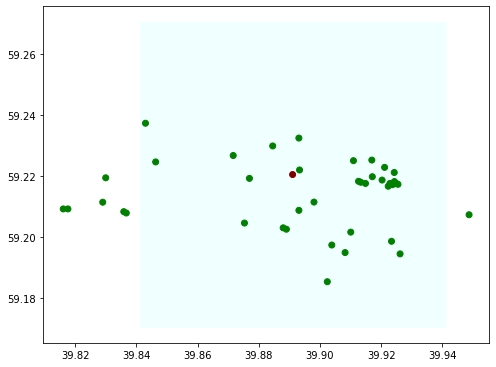

In [36]:
plotItems(houseItems, 'green', borders, center)

### Выводим результат прогноза

<AxesSubplot:>

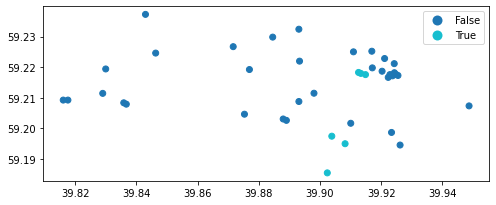

In [37]:
gdfItems.plot(column='book', legend=True, figsize=(8,8))

In [43]:
# Сохраняем финальный набор данных

dfBooks = pd.DataFrame()
dfBooks['lon'] = pd.DataFrame(gdfItems.geometry.x)
dfBooks['lat'] = pd.DataFrame(gdfItems.geometry.y)
dfBooks['book'] = gdfItems['book']
dfBooks.to_csv('predicted.csv', index=False)